In [1]:
import os
import shutil
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['NUMEXPR_MAX_THREADS'] = '48'
os.environ['NUMEXPR_NUM_THREADS'] = '48'
os.environ['OMP_THREAD_LIMIT'] = '48'
os.environ["OMP_NUM_THREADS"] = "48"
os.environ["OPENBLAS_NUM_THREADS"] = "48" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "48" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "48" # export VECLIB_MAXIMUM_THREADS=4
import gc
from datetime import datetime
from osgeo import gdal, gdal_array
from pathlib import Path
from typing import Callable, Iterator, List,                Union
import bottleneck as bn
import geopandas as gpd
import numpy as np
import pandas as pd
import skmap_bindings as sb
import tempfile
import time
import sys
import csv
from scipy.signal import savgol_coeffs
import numpy as np
from skmap.io import process
import matplotlib.pyplot as plt
import multiprocessing

gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}

co = ['TILED=YES', 'BIGTIFF=YES', 'COMPRESS=DEFLATE', 'BLOCKXSIZE=1024', 'BLOCKYSIZE=1024']

executor = None

def ttprint(*args, **kwargs):
        from datetime import datetime
        import sys

        print(f'[{datetime.now():%H:%M:%S}] ', end='')
        print(*args, **kwargs, flush=True)

def make_tempdir(basedir='skmap', make_subdir = True):
        tempdir = Path(TMP_DIR).joinpath(basedir)
        if make_subdir: 
                name = Path(tempfile.NamedTemporaryFile().name).name
                tempdir = tempdir.joinpath(name)
        tempdir.mkdir(parents=True, exist_ok=True)
        return tempdir

def make_tempfile(basedir='skmap', prefix='', suffix='', make_subdir = False):
        tempdir = make_tempdir(basedir, make_subdir=make_subdir)
        return tempdir.joinpath(
                Path(tempfile.NamedTemporaryFile(prefix=prefix, suffix=suffix).name).name
        )

def sb_arr(size):
        return np.empty(size, dtype=np.float32)

x_size, y_size = (4800, 4800)
n_pix = x_size * y_size
x_off, y_off = (0,0)
n_threads = multiprocessing.cpu_count()
no_data, delc, mod_decl, stress, stable, incr = (0, 1, 2, 3, 4, 5)
bands_list = [1,]
p_values_th = 0.05
baseline_range = range(0,12)
target_range = range(12,15)

target_year = 2015
data_dir = 'data_mirova'
soil_type_file = data_dir + '/TAXOUSDA_250m_ll.tif'
years = range(target_year-15,target_year)
n_years = len(years)
assert years[0] >= 2000, "Data not available before 2000, the target year should be after 2015"
# @TODO check also that the max year is lower then the currnt one
# Store file paths in a dictionary
files_by_year = {year: [] for year in years}
for filename in os.listdir(data_dir):
        if filename.startswith('MOD13Q1.A') and filename.endswith('_ndvi.tif'):
                year = int(filename[9:13])
                if year in years:
                        file_path = os.path.join(data_dir, filename)
                        files_by_year[year].append(file_path)


In [2]:
start = time.time()
# Check that all files are there and compute the NDVI integrals
NDVI_integrals = sb_arr((n_years, n_pix))
for i, year in enumerate(years):
        n_year_files = len(files_by_year[year])
        if year == 2000:
                assert n_year_files == 20, f"Error in the data download, not enough files for the year {year}"
        else:
                assert n_year_files == 23, f"Error in the data download, not enough files for the year {year}"
        NDVI_tmp = sb_arr((n_year_files, n_pix))
        NDVI_tmp_t = sb_arr(NDVI_tmp.shape[::-1])
        sb.readData(NDVI_tmp, n_threads, files_by_year[year], range(n_year_files), x_off, y_off, x_size, y_size, bands_list, gdal_opts, -3000, np.nan)
        sb.transposeArray(NDVI_tmp, n_threads, NDVI_tmp_t)
        sb.nanMean(NDVI_tmp_t, n_threads, NDVI_integrals[i])
ttprint(f"Reading data and computing NDVI integrals: {(time.time() - start):.2f} sec")


[15:33:35] Reading data and computing NDVI integrals: 20.19 sec


## Compute the trend flag

In [3]:
start = time.time()
NDVI_integrals_t = sb_arr((n_pix, n_years))
sb.transposeArray(NDVI_integrals, n_threads, NDVI_integrals_t)
time_samples = np.arange(n_years).astype(np.float32)
slope = sb_arr((n_pix,))
intercept = sb_arr((n_pix,))
sb.linearRegression(NDVI_integrals_t, n_threads, time_samples, intercept, slope)
ttprint(f"Computing linear regression: {(time.time() - start):.2f} sec")     

start = time.time()
p_values = sb_arr((n_pix,))
sb.computeMannKendallPValues(NDVI_integrals_t, n_threads, p_values)
ttprint(f"Computing p-values: {(time.time() - start):.2f} sec")     

start = time.time()
trend = np.sign(slope)
trend[p_values > p_values_th] = 0.
ttprint(f"Defining trend flag: {(time.time() - start):.2f} sec")     

[15:33:35] Computing linear regression: 0.38 sec
[15:33:37] Computing p-values: 2.10 sec
[15:33:38] Defining trend flag: 0.17 sec


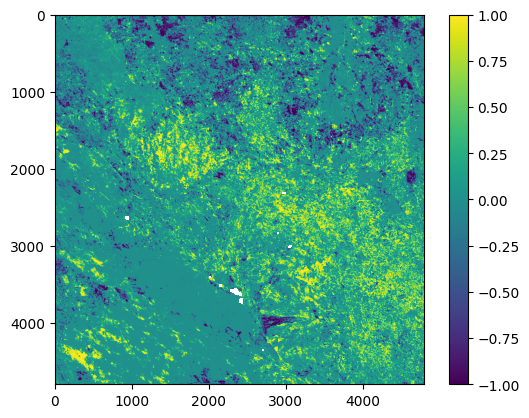

In [4]:
plt.imshow(np.reshape(trend,(x_size, y_size)))
plt.colorbar()
plt.show()

## Compute the state flag

In [5]:
start = time.time()
percentiles = np.linspace(10,90,9).astype(np.float32)
baseline_NDVI_integrals_t = sb_arr((n_pix,len(baseline_range)))
target_NDVI_integrals_t = sb_arr((n_pix,len(target_range)))
baseline_NDVI_integrals = sb_arr((len(baseline_range), n_pix))
target_NDVI_integrals = sb_arr((len(target_range), n_pix))
sb.extractArrayRows(NDVI_integrals, n_threads, baseline_NDVI_integrals, baseline_range)
sb.extractArrayRows(NDVI_integrals, n_threads, target_NDVI_integrals, target_range)
sb.transposeArray(baseline_NDVI_integrals, n_threads, baseline_NDVI_integrals_t)
sb.transposeArray(target_NDVI_integrals, n_threads, target_NDVI_integrals_t)
baseline_perc_t = sb_arr((n_pix, len(percentiles)))
baseline_NDVI_mean = sb_arr((n_pix))
target_NDVI_mean = sb_arr((n_pix))
baseline_class = np.zeros((n_pix), dtype=np.float32)
target_class = np.zeros((n_pix), dtype=np.float32)
state = np.zeros((n_pix), dtype=np.float32)
sb.computePercentiles(baseline_NDVI_integrals_t, n_threads, baseline_perc_t, 0, percentiles)
sb.nanMean(baseline_NDVI_integrals_t, n_threads, baseline_NDVI_mean)
sb.nanMean(target_NDVI_integrals_t, n_threads, target_NDVI_mean)
ttprint(f"Compute percentiles and means: {(time.time() - start):.2f} sec")
start = time.time()
for i in range(len(percentiles)):
        baseline_class[baseline_NDVI_mean > baseline_perc_t[:,i]] = i + 1
        target_class[target_NDVI_mean > baseline_perc_t[:,i]] = i + 1
class_diff = target_class - baseline_class
state[class_diff < -1] = -1.
state[class_diff > 1] = 1.
ttprint(f"Get state flag: {(time.time() - start):.2f} sec")

[15:33:41] Compute percentiles and means: 1.12 sec
[15:33:44] Get state flag: 2.92 sec


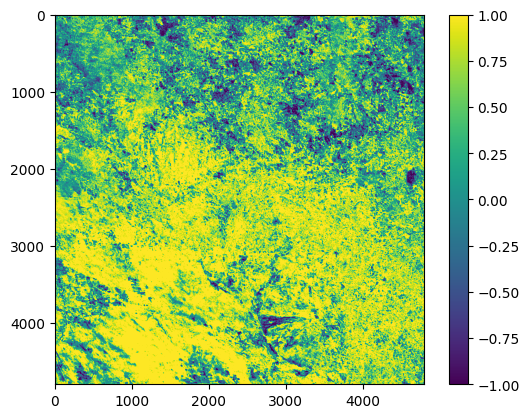

In [6]:
plt.imshow(np.reshape(state,(x_size, y_size)))
plt.colorbar()
plt.show()

## Performance

In [30]:
start = time.time()
soil_type_data = sb_arr((n_pix))
sb.warpTile(soil_type_data, n_threads, gdal_opts, files_by_year[years[0]][0], soil_type_file, "GRA_NearestNeighbour")
ttprint(f"Reading soil type: {(time.time() - start):.2f} sec")

start = time.time()
performance = np.zeros((n_pix), dtype=np.float32)
unique_soil_type = np.unique(soil_type_data)
NDVI_mean = sb_arr((n_pix))
max_prod = sb_arr((1,1))
sb.nanMean(NDVI_integrals_t, n_threads, NDVI_mean)
for i, soil_type in enumerate(unique_soil_type):
    mask = (soil_type_data == soil_type)
    NDVI_sel = NDVI_mean[mask].reshape(1, -1).copy()
    sb.computePercentiles(NDVI_sel, n_threads, max_prod, 0, [90.])
    performance[mask] = np.where(NDVI_sel[0] < (max_prod[0, 0] * 0.5), -1, performance[mask])
ttprint(f"Producing performance mask: {(time.time() - start):.2f} sec")

[15:59:42] Reading soil type: 5.15 sec
[15:59:46] Producing performance mask: 4.11 sec


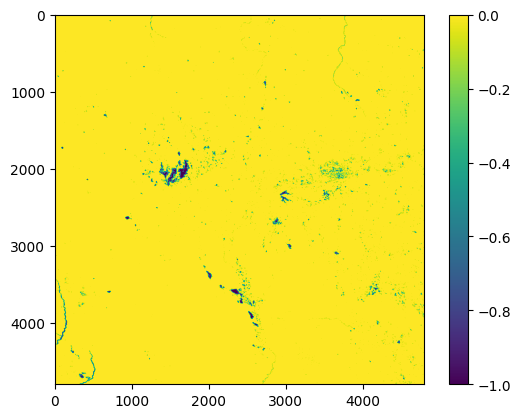

In [31]:
plt.imshow(np.reshape(performance,(x_size, y_size)))
plt.colorbar()
plt.show()

# Derive land productivty sub-indicator

In [33]:
# ttprint(f"Processing file")

start = time.time()
prod_subind = sb_arr((n_pix))
prod_subind = np.where((trend == 1.) & (state == 1.) & (performance == 0.), incr, prod_subind)
prod_subind = np.where((trend == 1.) & (state == 1.) & (performance == -1.), incr, prod_subind)
prod_subind = np.where((trend == 1.) & (state == 0.) & (performance == 0.), incr, prod_subind)
prod_subind = np.where((trend == 1.) & (state == 0.) & (performance == -1.), incr, prod_subind)
prod_subind = np.where((trend == 1.) & (state == -1.) & (performance == 0.), incr, prod_subind)
prod_subind = np.where((trend == 1.) & (state == -1.) & (performance == -1.), mod_decl, prod_subind)

prod_subind = np.where((trend == 0.) & (state == 1.) & (performance == 0.), stable, prod_subind)
prod_subind = np.where((trend == 0.) & (state == 1.) & (performance == -1.), stable, prod_subind)
prod_subind = np.where((trend == 0.) & (state == 0.) & (performance == 0.), stable, prod_subind)
prod_subind = np.where((trend == 0.) & (state == 0.) & (performance == -1.), stress, prod_subind)
prod_subind = np.where((trend == 0.) & (state == -1.) & (performance == 0.), mod_decl, prod_subind)
prod_subind = np.where((trend == 0.) & (state == -1.) & (performance == -1.), delc, prod_subind)


prod_subind = np.where((trend == -1.) & (state == 1.) & (performance == 0.), delc, prod_subind)
prod_subind = np.where((trend == -1.) & (state == 1.) & (performance == -1.), delc, prod_subind)
prod_subind = np.where((trend == -1.) & (state == 0.) & (performance == 0.), delc, prod_subind)
prod_subind = np.where((trend == -1.) & (state == 0.) & (performance == -1.), delc, prod_subind)
prod_subind = np.where((trend == -1.) & (state == -1.) & (performance == 0.), delc, prod_subind)
prod_subind = np.where((trend == -1.) & (state == -1.) & (performance == -1.), delc, prod_subind)


ttprint(f"Producing final land productivity sub-indicator mask: {(time.time() - start):.2f} sec")
# out_raseter = [f'test_Mirova_prod_subind_{i}' for i in range(len(out_data))]
# base_raseter = [files_by_year[years[0]][0] for i in range(len(out_data))]

# start = time.time()
# sb.writeByteData(out_data, n_threads, gdal_opts, base_raseter, f'/home/dconsoli/Desktop', out_raseter, range(len(out_raseter)),
#         x_off, y_off, x_size, y_size, 0)
# ttprint(f"Saving data: {(time.time() - start):.2f} segs")


[16:09:30] Producing final land productivity sub-indicator mask: 1.90 sec


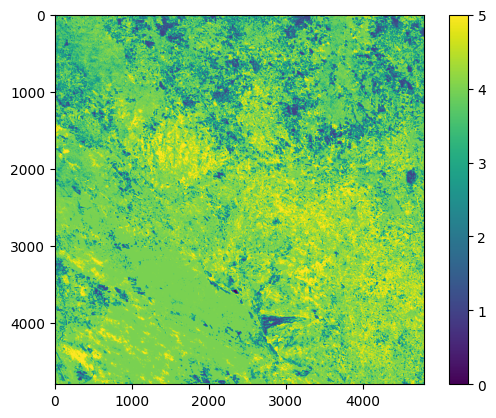

In [34]:
plt.imshow(np.reshape(prod_subind,(x_size, y_size)))
plt.colorbar()
plt.show()